In [ ]:
# prompt: !pip install yfinance

!pip install yfinance


[*********************100%***********************]  1 of 1 completed


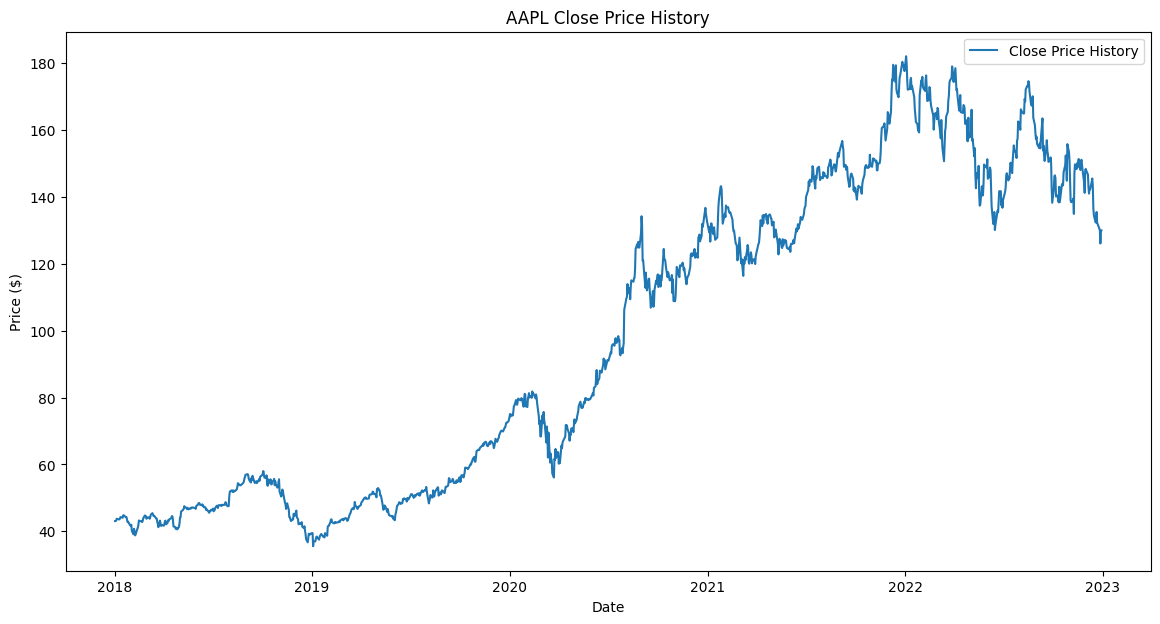

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Define the ticker symbol
ticker = "AAPL"

# Fetch historical data for the past 5 years
data = yf.download(ticker, start = "2018-01-01", end = "2023-01-01")

# Display the first few rows
data.head()

# Visualize the closing prices
plt.figure(figsize = (14, 7))
plt.plot(data['Close'], label = "Close Price History")
plt.title(f"{ticker} Close Price History")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.show()

In [ ]:
# Check data for missing values
print(data.isnull().sum())

# Fill missing values (if any) with the previous value
data.fillna(method = "ffill", inplace = True)


Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


<ipython-input-5-c0c3c2213269>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method = "ffill", inplace = True)


In [ ]:
# define the number of days to look back
look_back = 60

# Initialize lists to hold features and labels
x = []
y = []

# Loop to create the dataset
for i in range(look_back, len(data)):
  x.append(data['Close'].values[i-look_back:i])
  y.append(data["Close"].values[i])

# Convert to numpy arrays
x, y = np.array(x), np.array(y)

# Split the data into training and testing sets (80 % train, 20 % test)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, shuffle = False)

print(f"Training set size: {x_train.shape}")
print(f"Testing set size: {x_test.shape}")

Training set size: (959, 60)
Testing set size: (240, 60)


In [ ]:
# Initialize the Linear Regression Model
model = LinearRegression()

# Train the model
model.fit(x_train, y_train)

# Predict on the test set
predictions = model.predict(x_test)

# Calculate mean absolute error
mae = mean_absolute_error(y_test, predictions)
print(f"Mean Absolute Error: {mae:.2f}")

# Calculate the root mean squared error
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error: {rmse:.2f}")

Mean Absolute Error: 2.90
Root Mean Squared Error: 3.65


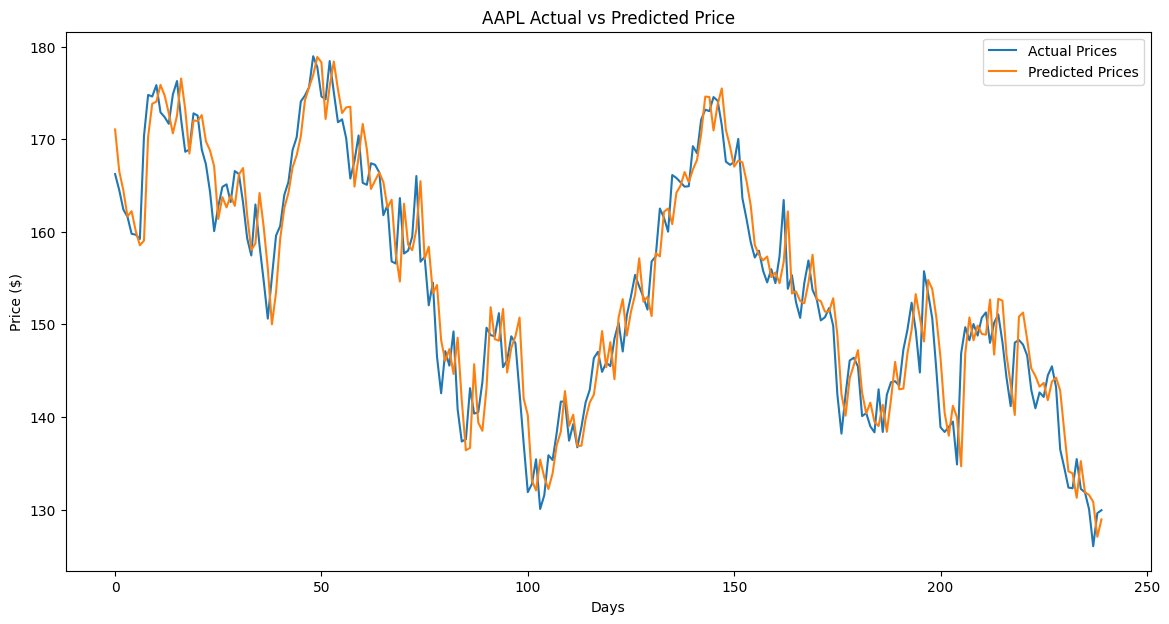

In [ ]:
plt.figure(figsize = (14, 7))
plt.plot(y_test, label="Actual Prices")
plt.plot(predictions, label = "Predicted Prices")
plt.title(f"{ticker} Actual vs Predicted Price")
plt.xlabel("Days")
plt.ylabel("Price ($)")
plt.legend()
plt.show()

In [ ]:
# Calculate 20 day and 50 day moving averages
data["MA20"] = data["Close"].rolling(window = 20).mean()
data["MA50"] = data["Close"].rolling(window = 50).mean()

# Fill missing values
data.fillna(method = "ffill", inplace = True)

# Update feature creation to include moving averages
look_back = 60
x = []
y = []

for i in range(look_back, len(data)):
  x.append(data[["Close", "MA20", "MA50"]].values[i - look_back:i])
  y.append(data["Close"].values[i])


x, y = np.array(x), np.array(y)


# Reshape x for models that requrie 2D input
x = x.reshape((x.shape[0], x.shape[1] * x.shape[2]))

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, shuffle = False)


<ipython-input-9-9d749c21af42>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method = "ffill", inplace = True)


In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the random forest model
rf_model = RandomForestRegressor(n_estimators = 100, random_state = 42)

# Train the model
rf_model.fit(x_train, y_train)

# Predict on the test set
rf_predictions = rf_model.predict(x_test)

# Evaluate the mdoel
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))

print(f"Random Forest MAE: {rf_mae:.2f}")
print(f"Random Forest RMSE: {rf_rmse:.2f}")



Random Forest MAE: 9.07
Random Forest RMSE: 11.03


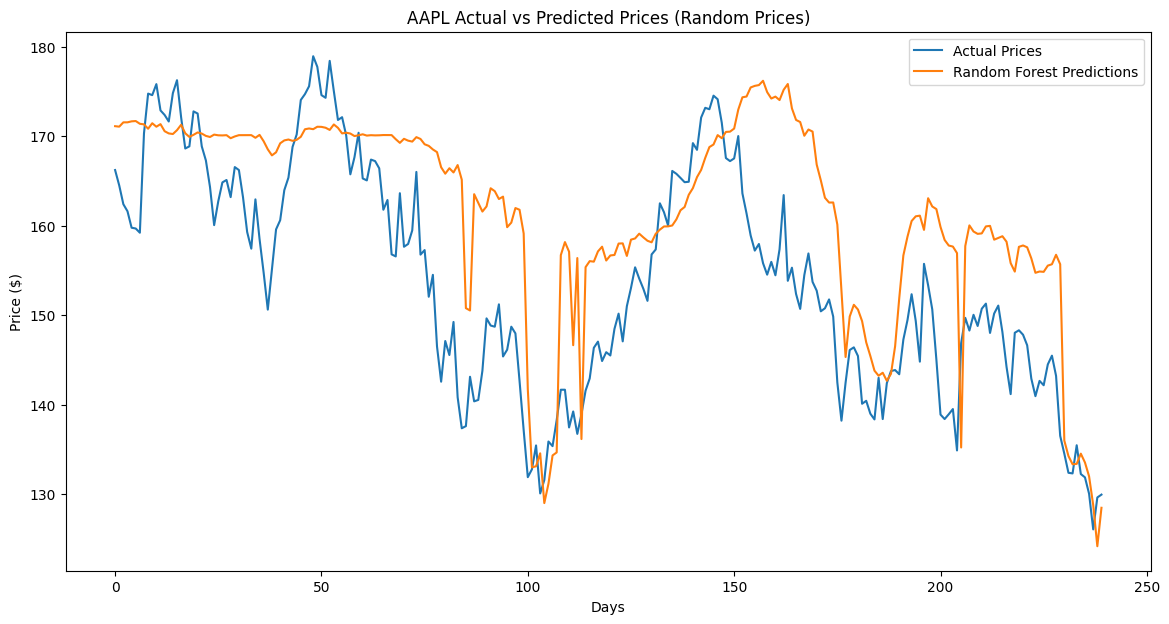

In [ ]:
plt.figure(figsize = (14, 7))
plt.plot(y_test, label = "Actual Prices")
plt.plot(rf_predictions, label = "Random Forest Predictions")
plt.title(f"{ticker} Actual vs Predicted Prices (Random Prices)")
plt.xlabel("Days")
plt.ylabel("Price ($)")
plt.legend()
plt.show()


In [ ]:
# Function to calulate RSI
def calculate_RSI(data, window = 14):
  delta = data["Close"].diff()
  gain = (delta.where(delta > 0, 0)).rolling(window = window).mean()
  loss = (-delta.where(delta < 0, 0)).rolling(window = window).mean()
  RS = gain / loss
  RSI = 100 - (100 / (1 + RS))
  return RSI

# Function to calculate MACD and Signal Line
def calculate_MACD(data, span_short = 12, span_long = 26, span_signal = 9):
  EMA_short = data["Close"].ewm(span=span_short, adjust = False).mean()
  EMA_long = data["Close"].ewm(span = span_long, adjust = False).mean()
  MACD = EMA_short - EMA_long
  signal_line = MACD.ewm(span = span_signal, adjust = False).mean()
  return MACD, signal_line

# Function to calculate Bollinger Bands
def calculate_Bollinger_Bands(data, window = 20, num_std = 2):
  MA = data["Close"].rolling(window = window).mean()
  STD = data["Close"].rolling(window = window).std()
  Upper_Band = MA + (STD * num_std)
  Lower_Band = MA - (STD * num_std)
  return MA, Upper_Band, Lower_Band

# Calculate RSI
data["RSI"] = calculate_RSI(data, window = 14)

# Calculate MACD and signal line
data["MACD"], data["Signal_Line"] = calculate_MACD(data)

# Calculate the Bollinger Bands
data["Middle_Band"], data["Upper_Band"], data["Lower_Band"] =  calculate_Bollinger_Bands(data)

# Drop the rows with NaN values resulting from technical indicators
data.dropna(inplace = True)

# Display the updated data
data.head()

,Open,High,Low,Close,Adj Close,Volume,MA20,MA50,RSI,MACD,...,lag_3,lag_4,lag_5,Day_sin,Day_cos,Month_sin,Month_cos,Signal_Line,Upper_Band,Lower_Band
Date,,,,,,,,,,,,,,,,,,,,,
2018-08-21,54.200001,54.297501,53.507500,53.759998,51.225636,104639200,51.339875,48.79410,76.822452,1.261180,...,53.330002,52.560001,52.437500,0.781831,0.623490,-0.866025,-0.5,1.034438,55.685549,46.994202
2018-08-22,53.525002,54.090000,53.459999,53.762501,51.228016,76072400,51.592750,48.90795,69.783020,1.256414,...,54.395000,53.330002,52.560001,0.974928,-0.222521,-0.866025,-0.5,1.078833,55.881065,47.304436
2018-08-23,53.662498,54.262501,53.650002,53.872501,51.332825,75532800,51.858750,49.03190,69.531207,1.247136,...,53.865002,54.395000,53.330002,0.433884,-0.900969,-0.866025,-0.5,1.112494,56.010854,47.706647
2018-08-24,54.150002,54.224998,53.777500,54.040001,51.492432,73905600,52.173500,49.15870,68.866369,1.239017,...,53.759998,53.865002,54.395000,-0.433884,-0.900969,-0.866025,-0.5,1.137799,55.949976,48.397025
2018-08-27,54.287498,54.685001,54.082500,54.485001,51.916458,82100400,52.523875,49.30420,79.097216,1.254035,...,53.762501,53.759998,53.865002,0.000000,1.000000,-0.866025,-0.5,1.161046,55.721860,49.325891


In [ ]:
# Calculate 20 - day and 50 - day volume moving averages
data["Volume_Avg20"] = data["Volume"].rolling(window = 20).mean()
data["Volume_Avg50"] = data["Volume"].rolling(window = 50).mean()

# Drop rows with NaN values resulting from volume averages
data.dropna(inplace = True)

# Display the updated data
data.head()

,Open,High,Low,Close,Adj Close,Volume,MA20,MA50,RSI,MACD,Signal Line,Middle_Band,Upper Band,Lower Band,Volume_Avg20,Volume_Avg50
Date,,,,,,,,,,,,,,,,
2018-05-23,46.587502,47.125000,46.439999,47.090000,44.713257,80233600,45.432625,43.87705,74.561056,1.050898,1.011909,45.432625,50.033434,40.831817,123528020.0,128037328.0
2018-05-24,47.192501,47.209999,46.552502,47.037498,44.663410,92936000,45.731750,43.92560,62.996382,1.020582,1.013644,45.731750,49.890896,41.572604,122582220.0,127546576.0
2018-05-25,47.057499,47.412498,46.912498,47.145000,44.765488,69844000,46.060000,43.97525,60.877866,0.993775,1.009670,46.060000,49.477283,42.642717,118943260.0,127123952.0
2018-05-29,46.900002,47.187500,46.717499,46.974998,44.604050,90056400,46.343000,44.02465,55.963867,0.947887,0.997313,46.343000,48.946239,43.739761,114960600.0,125772704.0
2018-05-30,46.930000,47.000000,46.695000,46.875000,44.509109,74762000,46.573000,44.08565,50.479450,0.893155,0.976482,46.573000,48.342119,44.803881,107984820.0,124592200.0


In [ ]:
# Create lagged features for the past 5 days
for lag in range(1, 6):
  data[f"lag_{lag}"] = data["Close"].shift(lag)

# Drop rows with NaN values resulting from lagged features
data.dropna(inplace = True)

# Display the updated data
data.head()

,Open,High,Low,Close,Adj Close,Volume,MA20,MA50,RSI,MACD,...,Middle_Band,Upper Band,Lower Band,Volume_Avg20,Volume_Avg50,lag_1,lag_2,lag_3,lag_4,lag_5
Date,,,,,,,,,,,,,,,,,,,,,
2018-05-31,46.805000,47.057499,46.535000,46.717499,44.359558,109931200,46.701750,44.14380,37.370528,0.827531,...,46.701750,48.051096,45.352403,100173500.0,125218872.0,46.875000,46.974998,47.145000,47.037498,47.090000
2018-06-01,46.997501,47.564999,46.937500,47.560001,45.159542,93770000,46.868625,44.23865,55.701476,0.833894,...,46.868625,47.619969,46.117280,98048360.0,124129880.0,46.717499,46.875000,46.974998,47.145000,47.037498
2018-06-04,47.910000,48.355000,47.837502,47.957500,45.536980,105064800,46.968625,44.35355,61.779787,0.861085,...,46.968625,47.741448,46.195801,92061340.0,122911912.0,47.560001,46.717499,46.875000,46.974998,47.145000
2018-06-05,48.267502,48.485001,48.090000,48.327499,45.888306,86264000,47.070500,44.49540,72.319651,0.902092,...,47.070500,47.989928,46.151071,87884260.0,121354888.0,47.957500,47.560001,46.717499,46.875000,46.974998
2018-06-06,48.407501,48.520000,47.980000,48.494999,46.047344,83734400,47.169625,44.60145,70.251375,0.937301,...,47.169625,48.249266,46.089983,86390420.0,120026280.0,48.327499,47.957500,47.560001,46.717499,46.875000


In [ ]:
# Extract date-related features
data["Day_of_Week"] = data.index.dayofweek # Monday = 0, Sunday = 6
data["Month"] = data.index.month

# Create cyclical features for Day_of_Week and Month
data["Day_sin"] = np.sin(2 * np.pi * data["Day_of_Week"] / 7)
data["Day_cos"] = np.cos(2 * np.pi * data["Day_of_Week"] / 7)
data["Month_sin"] = np.sin(2 * np.pi * data["Month"] / 12)
data["Month_cos"] = np.cos(2 * np.pi * data["Month"] / 12)

# Drop original Day_of_Week and Month columns
data.drop(["Day_of_Week", "Month"], axis = 1, inplace = True)

# Display the updated data
data.head()


,Open,High,Low,Close,Adj Close,Volume,MA20,MA50,RSI,MACD,...,Volume_Avg50,lag_1,lag_2,lag_3,lag_4,lag_5,Day_sin,Day_cos,Month_sin,Month_cos
Date,,,,,,,,,,,,,,,,,,,,,
2018-05-31,46.805000,47.057499,46.535000,46.717499,44.359558,109931200,46.701750,44.14380,37.370528,0.827531,...,125218872.0,46.875000,46.974998,47.145000,47.037498,47.090000,0.433884,-0.900969,5.000000e-01,-0.866025
2018-06-01,46.997501,47.564999,46.937500,47.560001,45.159542,93770000,46.868625,44.23865,55.701476,0.833894,...,124129880.0,46.717499,46.875000,46.974998,47.145000,47.037498,-0.433884,-0.900969,1.224647e-16,-1.000000
2018-06-04,47.910000,48.355000,47.837502,47.957500,45.536980,105064800,46.968625,44.35355,61.779787,0.861085,...,122911912.0,47.560001,46.717499,46.875000,46.974998,47.145000,0.000000,1.000000,1.224647e-16,-1.000000
2018-06-05,48.267502,48.485001,48.090000,48.327499,45.888306,86264000,47.070500,44.49540,72.319651,0.902092,...,121354888.0,47.957500,47.560001,46.717499,46.875000,46.974998,0.781831,0.623490,1.224647e-16,-1.000000
2018-06-06,48.407501,48.520000,47.980000,48.494999,46.047344,83734400,47.169625,44.60145,70.251375,0.937301,...,120026280.0,48.327499,47.957500,47.560001,46.717499,46.875000,0.974928,-0.222521,1.224647e-16,-1.000000


In [ ]:
# Define the feature columns to include
features_columns = [
    "Close", "MA20", "MA50", "RSI", "MACD", "Signal Line", "Upper Band", "Lower Band", "Volume_Avg20", "Volume_Avg50",
    'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'Day_sin', 'Day_cos', 'Month_sin', 'Month_cos'
]

# Ensure all selected features are present in the data
x = data[features_columns].values
y = data["Close"].values

In [ ]:
# Define the nummber of days to look back for features
look_back = 60

# Intialize lists to hold features and labels
x_final = []
y_final = []

# Loop to create the dataset
for i in range(look_back, len(data)):
  # Features: previous 60 days' selected features
  x_final.append(x[i - look_back:i].flatten())
  # Label: current day's Close price
  y_final.append(y[i])

# Convert to numpy arrays
x_final, y_final = np.array(x_final), np.array(y_final)

print(f"Feature matrix shape: {x_final.shape}")
print(f"Target vector shape: {y_final.shape}")

Feature matrix shape: (1039, 1140)
Target vector shape: (1039,)


In [ ]:
# Split the data into training and testing sets (80% train, 20% test)
x_train, x_test, y_train, y_test = train_test_split(x_final, y_final, test_size = 0.2, shuffle = False)

print(f"Training set size: {x_train.shape}")
print(f"Training set size: {x_test.shape}")

Training set size: (831, 1140)
Training set size: (208, 1140)


In [ ]:
# Linear Regression Model

# Initialize the Linear Regression Model
linear_model = LinearRegression()

# Train the model
linear_model.fit(x_train, y_train)

# Make predictions on the test set
linear_predictions = linear_model.predict(x_test)

# Evaluate the model
linear_mae = mean_absolute_error(y_test, linear_predictions)
linear_rmse = np.sqrt(mean_squared_error(y_test, linear_predictions))

print(f"Linear Regression MAE: {linear_mae:.2f}")
print(f"Linear Regression RMSE: {linear_rmse:.2f}")

Linear Regression MAE: 5.49
Linear Regression RMSE: 6.68


In [ ]:
# Random Forest Regressor Model

# Initialize the Random Forest Regressor with 100 trees
rf_model = RandomForestRegressor(n_estimators = 100, random_state = 42)

# Train the model
rf_model.fit(x_train, y_train)

# Make predictions on the test set
rf_predictions = rf_model.predict(x_test)

# Evaluate the model
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))

print(f"Random Forest MAE: {rf_mae:.2f}")
print(f"Random Forest RMSE: {rf_rmse:.2f}"

Random Forest MAE: 9.02
Random Forest RMSE: 10.79


In [ ]:
# Support Vector Regressor Model

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

# Initialize scalers
scaler_x = StandardScaler()
scaler_y = StandardScaler()

# Scale features and target
x_train_scaled = scaler_x.fit_transform(x_train)
x_test_scaled = scaler_x.transform(x_test)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()

# Initialize the SVR model with RBF kernel
svr_model = SVR(kernel = "rbf", C = 100, gamma = 0.1, epsilon = .1)

# Train the model
svr_model.fit(x_train_scaled, y_train_scaled)

# Make predictions on the test set
svr_predictions_scaled = svr_model.predict(x_test_scaled)

# Inverse transform the predictions
svr_predictions = scaler_y.inverse_transform(svr_predictions_scaled.reshape(-1, 1)).flatten()

# Evaluate the model
svr_mae = mean_absolute_error(y_test, svr_predictions)
svr_rmse = np.sqrt(mean_squared_error (y_test, svr_predictions))

print(f"Support Vector Regressor MAE: {svr_mae:.2f}")
print(f"Support Vector Regressor RMSE: {svr_rmse:.2f}")

Support Vector Regressor MAE: 53.78
Support Vector Regressor RMSE: 55.12


In [ ]:
# Long Short Term Memory Model

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping

# Reshape data for LSTM [samples, timesteps, features]
x_train_lstm =  x_train.reshape((x_train.shape[0], look_back, len(feature_columns)))
x_test_lstm = x_test.reshape((x_test.shape[0], look_back, len(feature_columns)))

# Build the LSTM model
lstm_model = Sequential([
    LSTM(50, return_sequences = True, input_shape = (look_back, len(feature_columns))),
    LSTM(50, return_sequences = False),
    Dense(25),
    Dense(1)
])

# Compile the model
lstm_model.compile(optimizer = "adam", loss = "mean_squared_error")

# Define Early stopping
early_stop = EarlyStopping(monitor = "val_loss", patience = 10)

# Train the model
lstm_model.fit(
    x_train_lstm, y_train,
    batch_size = 32,
    epochs = 100,
    validation_split = 0.1,
    callbacks = [early_stop],
    verbose = 1
)

# Make predictions on the test set
lstm_predictions = lstm_model.predict(x_test_lstm).flatten()

# Evaluate the model
lstm_mae = mean_absolute_error(y_test, lstm_predictions)
lstm_rmse = np.sqrt(mean_squared_error(y_test, lstm_predictions))

print(f"LSTM MAE: {lstm_mae:.2f}")
print(f"LSTM RMSE: {lstm_rmse:.2f}")

Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 9378.9365 - val_loss: 25998.0781
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 8132.1631 - val_loss: 22586.7598
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 6587.9717 - val_loss: 18538.6094
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 4549.5044 - val_loss: 14640.9346
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 3101.3938 - val_loss: 11283.6045
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 2100.7935 - val_loss: 8748.0186
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 1601.7762 - val_loss: 7189.2275
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 1412.7871 - val_loss: 6396.6289
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 1352.7634 - val_loss: 6072.2358
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 1422.9711 - val_loss: 6071.3291
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 1427.3973 - v

In [ ]:
# Create a dictionary to store the performance metrics

model_performance = {
    "Model": [],
    "MAE": [],
    "RMSE": []
}

# Populate the dictionary with performance metrics
model_performance["Model"].append("Linear Regression")
model_performance["MAE"].append(linear_mae)
model_performance["RMSE"].append(linear_rmse)

model_performance["Model"].append("Random Forest")
model_performance["MAE"].append(rf_mae)
model_performance["RMSE"].append(rf_rmse)

model_performance["Model"].append("Support Vector Regressor")
model_performance["MAE"].append(svr_mae)
model_performance["RMSE"].append(svr_rmse)

model_performance["Model"].append("LSTM Neural Network")
model_performance["MAE"].append(lstm_mae)
model_performance["RMSE"].append(lstm_rmse)

# Convert to DataFrame for better visualization
performance_df = pd.DataFrame(model_performance)

# Display the performance comparison
performance_df

,Model,MAE,RMSE
0,Linear Regression,5.491011,6.683537
1,Random Forest,9.023365,10.788426
2,Support Vector Regressor,53.780215,55.116774
3,LSTM Neural Network,58.862888,60.049100


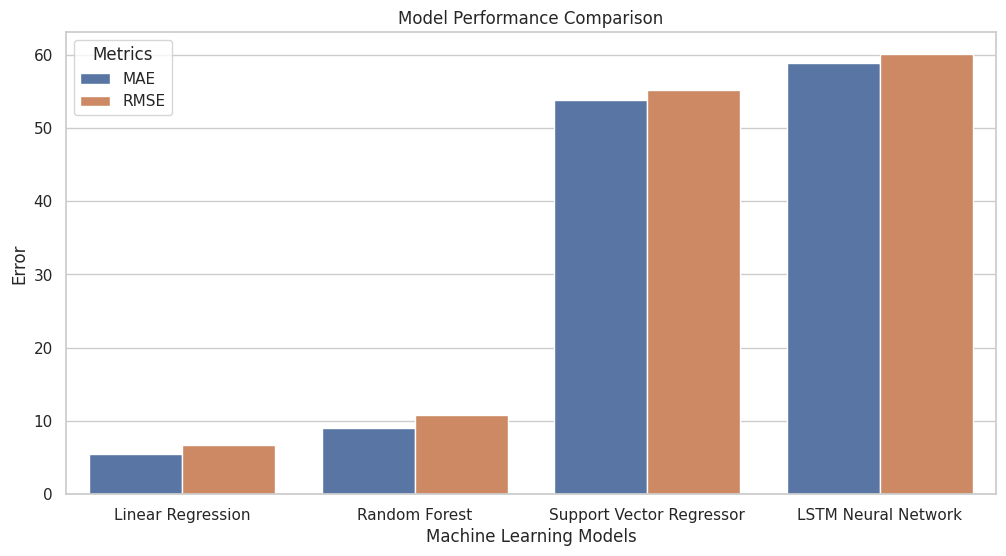

In [ ]:
import seaborn as sns

# Set the style for seaborn
sns.set(style="whitegrid")

# Melt the dataframe from seaborn compatibility
performance_melted = performance_df.melt(id_vars = "Model", var_name = "Metric", value_name = "Value")

# Create a bar plot
plt.figure(figsize = (12, 6))
sns.barplot(x = "Model", y = "Value", hue = "Metric", data = performance_melted)
plt.title("Model Performance Comparison")
plt.ylabel("Error")
plt.xlabel("Machine Learning Models")
plt.legend(title = "Metrics")
plt.show()

In [ ]:
# Adjusting test_dates to match the length of y_test
test_length = len(y_test)

# Extract test dates
test_dates = data.index[-test_length:]

# Create a dataframe to hold actual and predicted values
comparison_df = pd.DataFrame({
    "Date": test_dates,
    "Actual": y_test,
    "Linear Regression": linear_predictions,
    "Random Forest": rf_predictions,
    "SVR": svr_predictions,
    "LSTM": lstm_predictions
})

# Set "Date" as the index
comparison_df.set_index("Date", inplace = True)

# Display the first few rows
comparison_df.head()

,Actual,Linear Regression,Random Forest,SVR,LSTM
Date,,,,,
2022-03-07,159.300003,165.845114,163.015598,98.048824,93.172897
2022-03-08,157.440002,162.418616,162.795399,98.048824,93.180099
2022-03-09,162.949997,160.014929,162.185199,98.048824,93.187523
2022-03-10,158.520004,161.817770,161.631000,98.048824,93.194458
2022-03-11,154.729996,156.504980,160.473200,98.048824,93.209839


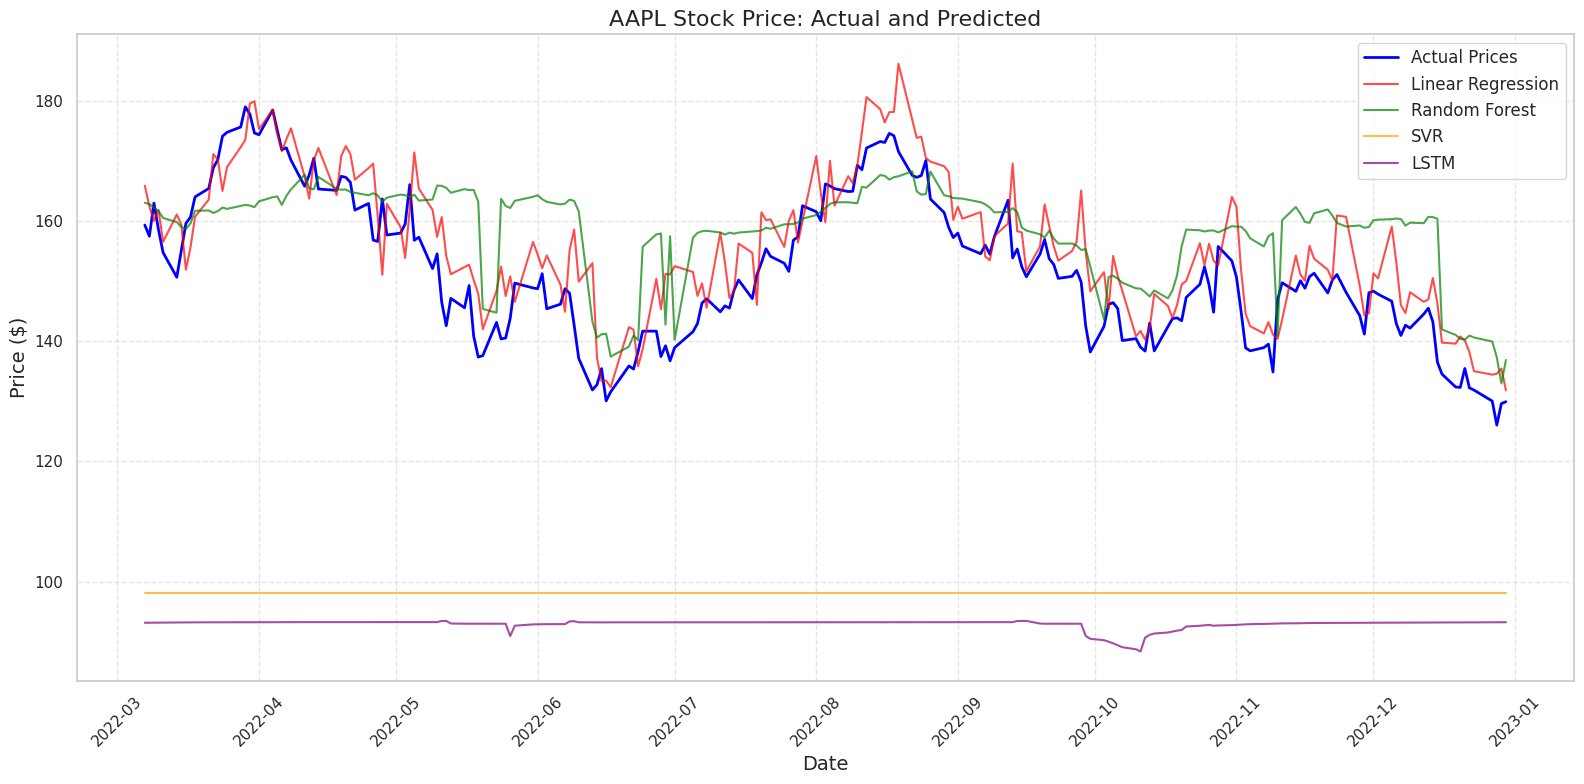

In [ ]:
# Plot the predictions vs actual values
plt.figure(figsize = (16, 8))

# Plot actual prices
plt.plot(comparison_df.index, comparison_df["Actual"], label = "Actual Prices", color = "blue", linewidth = 2)

# Plot predictions
plt.plot(comparison_df.index, comparison_df["Linear Regression"], label = "Linear Regression", color = "red", alpha = 0.7)
plt.plot(comparison_df.index, comparison_df["Random Forest"], label = "Random Forest", color = "green", alpha = 0.7)
plt.plot(comparison_df.index, comparison_df["SVR"], label = "SVR", color = "orange", alpha = 0.7)
plt.plot(comparison_df.index, comparison_df["LSTM"], label = "LSTM", color = "purple", alpha = 0.7)

# Add title and labels
plt.title("AAPL Stock Price: Actual and Predicted", fontsize = 16)
plt.xlabel("Date", fontsize = 14)
plt.ylabel("Price ($)", fontsize = 14)
plt.xticks(rotation = 45)
plt.legend(fontsize = 12)
plt.grid(True, linestyle = "--", alpha = 0.5)
plt.tight_layout()
plt.show()

